In [10]:
import os
import mindspore as ms
import mindspore.context as context
#transforms.c_transforms用于通用型数据增强，vision.c_transforms用于图像类数据增强
import mindspore.dataset.transforms.c_transforms as C
import mindspore.dataset.vision.c_transforms as CV
#nn模块用于定义网络，model模块用于编译模型，callback模块用于设定监督指标
from mindspore import nn
from mindspore.train import Model
from mindspore.train.callback import LossMonitor

# 导入Accuracy作为评价指标
from mindspore.nn.metrics import Accuracy
#设定运行模式为图模式，运行硬件为昇腾芯片->改为CPU
context.set_context(mode=context.GRAPH_MODE, device_target='CPU') # Ascend, CPU, GPU

In [11]:
# MindSpore内置方法读取MNIST数据集
train = ms.dataset.MnistDataset(os.path.join('./MNIST', "train"))
test = ms.dataset.MnistDataset(os.path.join('./MNIST', "test"))
# 该数据集可以通过create_dict_iterator()转换为迭代器形式，然后通过get_next()一个个输出样本
image = train.create_dict_iterator().get_next() # 训练集的图像迭代器

In [12]:
#根据数据集存储地址，生成数据集，默认采用的数据集是训练集
def create_dataset(training=True, batch_size=32, resize=(28, 28), rescale=1 / 255, shift=-0.5, buffer_size=64):
    d = train if training else test
    resize_op = CV.Resize(resize)
    rs_op = CV.Rescale(rescale, shift)
    hwc2chw_op = CV.HWC2CHW()
    d = d.map(input_columns="image", operations=[resize_op, rs_op, hwc2chw_op])
    d = d.map(input_columns="label", operations=C.TypeCast(ms.int32))
    d = d.shuffle(buffer_size=buffer_size)
    d = d.batch(batch_size, drop_remainder=True)

    return d

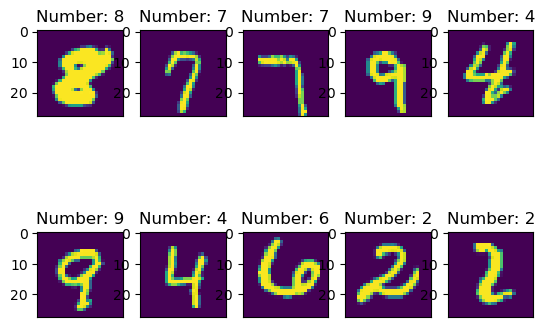

In [13]:
import matplotlib.pyplot as plt
import numpy as np

dataset_show = create_dataset(training=False)
data = dataset_show.create_dict_iterator().get_next()
images = data['image'].asnumpy()
labels = data['label'].asnumpy()

for i in range(1, 11):
    plt.subplot(2, 5, i)
    # 利用squeeze方法去掉多余的一个维度
    plt.imshow(np.squeeze(images[i]))
    plt.title('Number: %s' % labels[i])
    plt.xticks([])
plt.show()

In [14]:
class ForwardNN(nn.Cell):
    def __init__(self):
        super(ForwardNN, self).__init__()
        self.flatten = nn.Flatten()
        self.relu = nn.ReLU()
        self.fc1 = nn.Dense(784, 512, activation='relu')
        self.fc2 = nn.Dense(512, 256, activation='relu')
        self.fc3 = nn.Dense(256, 128, activation='relu')
        self.fc4 = nn.Dense(128, 64, activation='relu')
        self.fc5 = nn.Dense(64, 32, activation='relu')
        self.fc6 = nn.Dense(32, 10, activation='softmax')

    def construct(self, input_x):
        op = self.flatten(input_x)
        op = self.fc1(op)
        op = self.fc2(op)
        op = self.fc3(op)
        op = self.fc4(op)
        op = self.fc5(op)
        op = self.fc6(op)
        return op

In [19]:
from mindspore.train.callback import ModelCheckpoint, CheckpointConfig, LossMonitor

learn_rate = 0.001
net = ForwardNN()
loss = nn.loss.SoftmaxCrossEntropyWithLogits(sparse=True, reduction='mean')  # SoftmaxCrossEntropyWithLogits损失函数
accuracy = {"Accuracy": Accuracy()}
optimizer = nn.Adam(net.trainable_params(), learn_rate)  # Adam优化器
model = Model(net, loss, optimizer, accuracy)
ds_evaluation = create_dataset(False, batch_size=32)
ds_train = create_dataset(True, batch_size=32)

config = CheckpointConfig(save_checkpoint_steps=1875, keep_checkpoint_max=10)
kpt_callback = ModelCheckpoint(prefix="mnist", directory="./checkpoint", config=config)
loss_monitor = LossMonitor(300)

In [18]:
if __name__ == "__main__":
    print("Starting Training... ")
    num_epoch = 10
    model.train(num_epoch, ds_train, callbacks=[kpt_callback, loss_monitor], dataset_sink_mode=True)

    metrics_result = model.eval(ds_evaluation)
    print(metrics_result)

Starting Training... 


ValueError: The data pipeline is not a tree (i.e., one node has 2 consumers)